### Importando Bibliotecas e separando conjuntos de treino e validação

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Criando conjuntos de teste e validação

OBS: REALIZAR O TREINAMENTO COM AS FOTOS EM CORES DE CINZA PODE TRAZER MAIOR ACURÁCIA COM CORES DE FILMAENTOS DIFERNETES?

In [32]:
# Caminho para o diretório que contém as subpastas de classes
diretorio = 'imagens'

# Inicializa o gerador de dados com a opção de rescale e divisão de validação
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # reserva 20% das imagens para validação
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',   
)

# Cria o gerador de treino
train_generator = datagen.flow_from_directory(
    diretorio,
    target_size=(224, 224),  # redimensiona as imagens para 224x224
    batch_size=20,
    class_mode='binary',
    subset='training',  # define este conjunto como sendo de treinamento,
    shuffle=True
)

# Cria o gerador de validação
validation_generator = datagen.flow_from_directory(
    diretorio,
    target_size=(224, 224),  # redimensiona as imagens para 224x224
    batch_size=20,
    class_mode='binary',
    subset='validation',  # define este conjunto como sendo de validação
    shuffle=True
)

Found 2307 images belonging to 2 classes.
Found 575 images belonging to 2 classes.


In [33]:
diretorio_teste = 'imagens_teste'

test_datagen = ImageDataGenerator(rescale=1./255)

# Cria o gerador de teste
test_generator = test_datagen.flow_from_directory(
    diretorio_teste,
    target_size=(224, 224), 
    batch_size=20,
    class_mode='binary',
    shuffle=False 
)

Found 5 images belonging to 2 classes.


### Verificando algumas imagens

In [34]:
# Gera e exibe imagens de augmentação
def display_augmented_images(generator, num_images=5):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(15, 15))
    for i in range(num_images):
        # Obtem um batch de imagens
        img, label = next(generator)
        # Exibe a primeira imagem do batch (pois o tamanho do batch é 1)
        ax[i].imshow(img[0])
        ax[i].axis('off')
    plt.show()

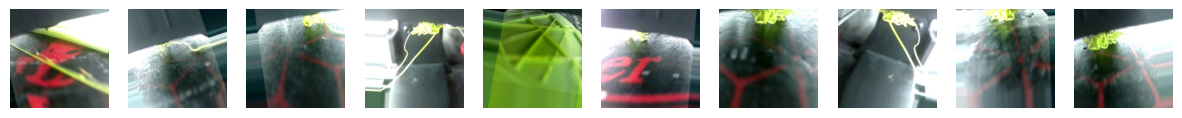

In [35]:
display_augmented_images(train_generator, num_images=10)

In [36]:
classes_train = train_generator.class_indices
classes_validation = validation_generator.class_indices

print("Classes no conjunto de treinamento:", classes_train)
print("Classes no conjunto de validação:", classes_validation)

Classes no conjunto de treinamento: {'corretas': 0, 'erradas': 1}
Classes no conjunto de validação: {'corretas': 0, 'erradas': 1}


In [37]:
# Contagem de imagens por classe no conjunto de treinamento
class_indices_train = train_generator.class_indices
labels_train = train_generator.labels
count_images_per_class_train = {class_name: labels_train.tolist().count(class_idx) for class_name, class_idx in class_indices_train.items()}

print("Quantidade de fotos por classe no conjunto de treinamento:", count_images_per_class_train)

# Contagem de imagens por classe no conjunto de validação
class_indices_validation = validation_generator.class_indices
labels_validation = validation_generator.labels
count_images_per_class_validation = {class_name: labels_validation.tolist().count(class_idx) for class_name, class_idx in class_indices_validation.items()}

print("Quantidade de fotos por classe no conjunto de validação:", count_images_per_class_validation)


Quantidade de fotos por classe no conjunto de treinamento: {'corretas': 1028, 'erradas': 1279}
Quantidade de fotos por classe no conjunto de validação: {'corretas': 256, 'erradas': 319}


In [38]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  
predictions = layers.Dense(1, activation='sigmoid')(x) 

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
model.compile(optimizer=Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=10,  # Depende do tamanho do seu conjunto de dados
    epochs=10,            # Ajuste conforme necessário
    validation_data=validation_generator,
    validation_steps=20,  # Depende do tamanho do seu conjunto de validação
    verbose=2)

Epoch 1/10
10/10 - 35s - 4s/step - accuracy: 0.5350 - loss: 0.7664 - val_accuracy: 0.4500 - val_loss: 0.7891
Epoch 2/10
10/10 - 20s - 2s/step - accuracy: 0.4600 - loss: 0.8385 - val_accuracy: 0.4171 - val_loss: 0.6750
Epoch 3/10


2024-04-05 17:33:07.870460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


10/10 - 29s - 3s/step - accuracy: 0.5100 - loss: 0.7902 - val_accuracy: 0.5850 - val_loss: 0.6725
Epoch 4/10
10/10 - 18s - 2s/step - accuracy: 0.4599 - loss: 0.7776 - val_accuracy: 0.6800 - val_loss: 0.5848
Epoch 5/10


2024-04-05 17:33:55.404584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


10/10 - 30s - 3s/step - accuracy: 0.5700 - loss: 0.7264 - val_accuracy: 0.7600 - val_loss: 0.6289
Epoch 6/10
10/10 - 19s - 2s/step - accuracy: 0.5550 - loss: 0.7198 - val_accuracy: 0.7943 - val_loss: 0.5489
Epoch 7/10


2024-04-05 17:34:44.473710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


10/10 - 31s - 3s/step - accuracy: 0.5850 - loss: 0.6893 - val_accuracy: 0.7925 - val_loss: 0.6125
Epoch 8/10
10/10 - 19s - 2s/step - accuracy: 0.6200 - loss: 0.6277 - val_accuracy: 0.8400 - val_loss: 0.5372
Epoch 9/10


2024-04-05 17:35:34.135225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


10/10 - 33s - 3s/step - accuracy: 0.5750 - loss: 0.6963 - val_accuracy: 0.8425 - val_loss: 0.5802
Epoch 10/10
10/10 - 21s - 2s/step - accuracy: 0.6300 - loss: 0.6339 - val_accuracy: 0.9086 - val_loss: 0.5126


2024-04-05 17:36:28.981844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [40]:
model.save_weights('my_model.weights.h5')

In [41]:
eval_result = model.evaluate(test_generator)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 1.0000 - loss: 0.5357
Test Loss: 0.5356692671775818, Test Accuracy: 1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


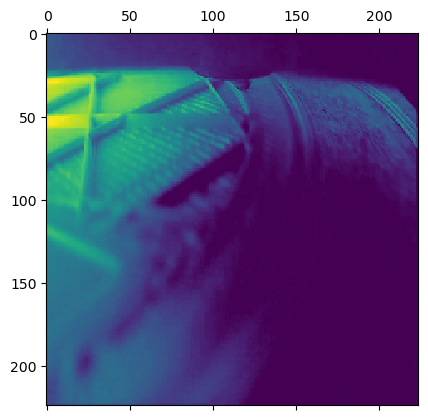

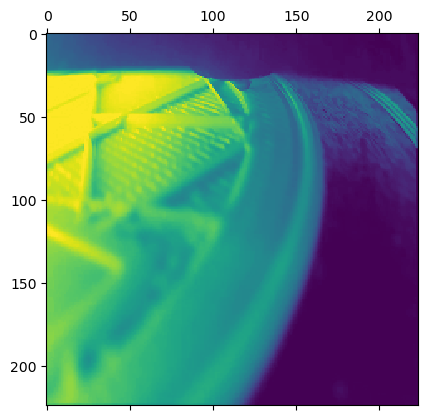

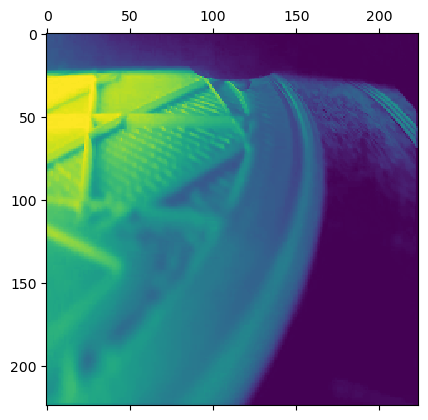

In [43]:
image_path = 'imagens_teste/corretas/frame1277.jpg'

img = image.load_img(image_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_input = preprocess_input(img_batch)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)  
activations = activation_model.predict(img_input) 
first_layer_activation = activations[0]
num_channels = first_layer_activation.shape[3]
for i in range(num_channels):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


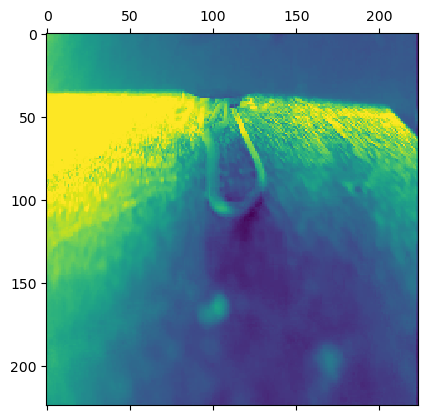

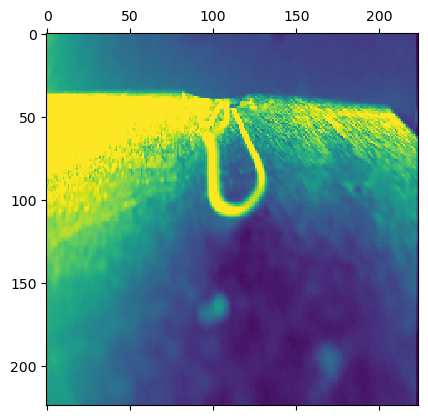

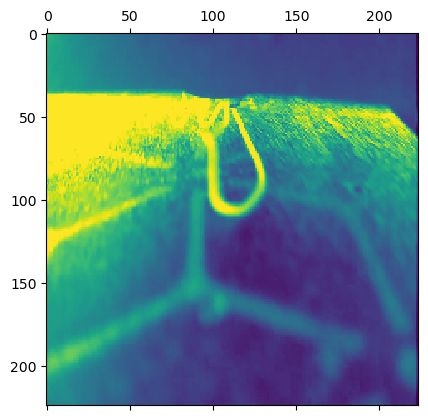

In [44]:
image_path = 'imagens_teste/erradas/frame1492.jpg'

img = image.load_img(image_path, target_size=(224, 224))

img_array = image.img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_input = preprocess_input(img_batch)

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)  
activations = activation_model.predict(img_input) 
first_layer_activation = activations[0]
num_channels = first_layer_activation.shape[3]
for i in range(num_channels):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')